Δουλεύουμε στο Google Colab και η GPU που χρησιμοποιούμε φαίνεται παρακάτω 

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Mar  4 19:47:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Βαθιά μάθηση στο CIFAR-100 

Στο σημείο αυτό θα αναλύσουμε τη στρατηγική που θα ακολουθήσουμε έτσι ώστε να βελτιώσουμε την επίδοση στο πρόβλημα ταξινόμησης CIFAR-100.



*   Δημιουργία TFrecords
*   Prefetch



**1ο Μέρος**

*   Transfer Learning σε 3 προεκπαιδευμένα μοντέλα που έχουν λίγες παραμέτρους (DenseNet121, ResNet50, Xceptin)
*   Particle Swarm Optimization για παρατήρηση αρχιτεκτονικής που εμφανίζει τα καλύτερα αποτελέσματα
*   Έχοντας σαν δεδομένα τις βέλτιστες αρχιτεκτονικές που αποφάνθηκε ο PSO αλγόριθμος, όπως επίσης και τις αντίστοιχες τιμές των μετρικών, θα προσπαθήσουμε να βελτιστοποιήσουμε το VGG 16 (Η αρχική μας σκέψη ήταν για το NASNetLarge αλλά υπάρχει ["πρόβλημα"](https://github.com/keras-team/keras-applications/issues/78) στην κατασκευή του που επιτρέπει μόνο (331,331,3) μέγεθος εικόνων και δεν επιθυμούσαμε να κάνουμε τόσο μεγάλες αλλαγές στο αρχικό (31,31,3) μέγεθος).

**2ο Μέρος**



*   Μέσα απο μια παρόμοια σειρά πειραμάτων που πραγματοποιήσαμε στο 1ο Μέρος θα κατασκευάσουμε "from scratch" ένα DCNN που να επιτυγχάνει καλή απόδοση στο πρόβλημα ταξινόμησης.





In [2]:
#@title
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
#@title
!pip install --upgrade pyswarm
!pip install pymc3
!pip install --upgrade pactools

from sklearn.model_selection import train_test_split
from pyswarm import pso
from os import path
import os
import requests
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import numpy
import sys
import numpy as np
from numpy import loadtxt
from numpy import array
from numpy.random import choice
import pandas as pd
import time
import random
import statistics
import pandas
import math
import csv
import random
import logging
from pymc3 import *
import pymc3 as pm
from functools import reduce
from operator import add
from tqdm import tqdm
import geopy.distance
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
from sklearn import preprocessing
print('Running on PyMC3 v{}'.format(pm.__version__))
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow
from tensorflow.keras import datasets, layers, models
from keras.utils import np_utils
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator

#TESNORFOW
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
#KERAS LIBRARIES
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout , Flatten,BatchNormalization,Conv2D,MaxPooling2D, Activation,LSTM,Embedding,Input,GlobalAveragePooling2D
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras import backend 
from keras.utils import np_utils
from keras.utils import to_categorical

  Created wheel for pyswarm: filename=pyswarm-0.6-cp37-none-any.whl size=4481 sha256=ffad7ca8bd3a34bf083ae9677b9428ab6c3b829fb72c513aebf73820cebf2b4c
  Stored in directory: /root/.cache/pip/wheels/37/c5/f6/b33b9ac00040cb95c1f00af982a4197334a672d6de43f4699f
Successfully built pyswarm
     |████████████████████████████████| 92kB 7.1MB/s 
     |████████████████████████████████| 6.9MB 12.0MB/s 
Running on PyMC3 v3.7


## Ανάγνωση Δεδεομένων και έτοιμες συναρτήσεις

In [4]:
#@title

def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)

In [5]:
#@title
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [6]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 6s 0us/step


In [7]:
# REPLACE WITH YOUR C NUMBER
team_sead = 195

In [8]:
# select the number of classes
cifar100_classes_url = select_classes_number(80)

In [9]:
#@title
my_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = my_classes.iloc[team_sead,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [10]:
# print our classes
print(our_classes)
CLASSES_NUM=len(our_classes)

['apple', ' aquarium_fish', ' baby', ' beaver', ' bed', ' bee', ' beetle', ' bottle', ' bowl', ' boy', ' bridge', ' bus', ' butterfly', ' camel', ' can', ' castle', ' cattle', ' chair', ' chimpanzee', ' clock', ' cloud', ' couch', ' crab', ' crocodile', ' cup', ' dinosaur', ' dolphin', ' elephant', ' forest', ' fox', ' girl', ' hamster', ' house', ' kangaroo', ' keyboard', ' leopard', ' lion', ' lizard', ' lobster', ' maple_tree', ' mountain', ' mouse', ' mushroom', ' oak_tree', ' orange', ' orchid', ' palm_tree', ' pear', ' pickup_truck', ' pine_tree', ' plain', ' poppy', ' porcupine', ' possum', ' rabbit', ' raccoon', ' ray', ' rocket', ' rose', ' sea', ' seal', ' skunk', ' snail', ' snake', ' spider', ' squirrel', ' streetcar', ' sunflower', ' sweet_pepper', ' table', ' tank', ' telephone', ' television', ' tiger', ' tractor', ' train', ' tulip', ' wardrobe', ' willow_tree', ' woman']


6000
Train: X=(34000, 32, 32, 3), y=(34000, 1)
Validation: X=(6000, 32, 32, 3), y=(6000, 1)
Test: X=(8000, 32, 32, 3), y=(8000, 1)


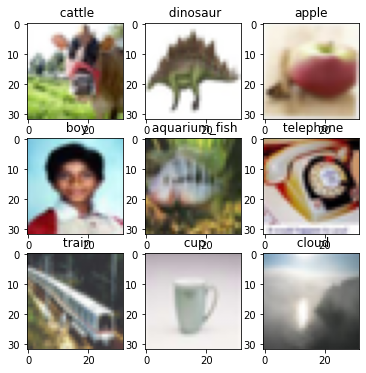

In [11]:
#@title
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

## TFRecords

### Write

Στο στάδιο αυτό θα γίνει ο μετασχηματισμός του μεγέθους. Συνεπώς πρέπει να ορίσουμε ποια pretrained μοντέλα θα χρησιμοποιήσουμε. Αυτά είναι τα εξής :



*   DenseNet121 (min shape (32,32,3))
*   Xception (min shape (71,71,3))
*   ResNet152 (min shape (32,32,3))
*   InceptionResNetV2(min shape(75,75,3))



In [12]:
TARGET_SIZE_1 = (71,71,3)
TARGET_SIZE_2 = (32,32,3)
TARGET_SIZE_3 = (75,75,3)
directory='/content/drive/My Drive/tfRecords'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [14]:
def serialize_example(image, label, image_shape):
    feature = {
        "image": _bytes_feature(image),
        "label": _int64_feature(label),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [15]:
def write_TFR(tfrecord_dir, x, y, target_size):
  with tf.io.TFRecordWriter(tfrecord_dir) as writer:
      for img_array, label in zip(x, y):
                
          img_array = tf.image.resize(img_array, (target_size[0], target_size[1]))
          
          img_bytes = tf.io.serialize_tensor(img_array)
          image_shape = img_array.shape
          
          example = serialize_example(img_bytes, label, image_shape)
          writer.write(example)
  return None

In [16]:
write_TFR(directory + "train32.tfrecords", x_train, y_train,TARGET_SIZE_2)
write_TFR(directory + "validation32.tfrecords", x_val, y_val,TARGET_SIZE_2)
write_TFR(directory + "test32.tfrecords", x_test, y_test,TARGET_SIZE_2)

write_TFR(directory + "train71.tfrecords", x_train, y_train,TARGET_SIZE_1)
write_TFR(directory + "validation71.tfrecords", x_val, y_val,TARGET_SIZE_1)
write_TFR(directory + "test71.tfrecords", x_test, y_test,TARGET_SIZE_1)

write_TFR(directory + "train75.tfrecords", x_train, y_train,TARGET_SIZE_3)
write_TFR(directory + "validation75.tfrecords", x_val, y_val,TARGET_SIZE_3)
write_TFR(directory + "test75.tfrecords", x_test, y_test,TARGET_SIZE_3)

### Read

In [25]:
def _parse_function1(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example_proto, feature_description)

    label = example["label"]
    image_shape = (71,71,3)

    image = tf.io.parse_tensor(example["image"], float)
    image = tf.reshape(image, image_shape)


    return  image , [label]

def _parse_function2(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example_proto, feature_description)

    label = example["label"]
    image_shape = (32,32,3)

    image = tf.io.parse_tensor(example["image"], float)
    image = tf.reshape(image, image_shape)


    return  (image , [label])

def _parse_function3(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example_proto, feature_description)

    label = example["label"]
    image_shape = (75,75,3)

    image = tf.io.parse_tensor(example["image"], float)
    image = tf.reshape(image, image_shape)


    return  (image , [label])

In [26]:
def read_dataset1(file):
    dataset = tf.data.TFRecordDataset(file)
    return dataset.map(_parse_function1)

def read_dataset2(file):
    dataset = tf.data.TFRecordDataset(file)
    return dataset.map(_parse_function2)

def read_dataset3(file):
    dataset = tf.data.TFRecordDataset(file)
    return dataset.map(_parse_function3)

In [27]:
train_71 = read_dataset1(directory + "train71.tfrecords")
validation_71 = read_dataset1(directory + "validation71.tfrecords")
test_71= read_dataset1(directory + "test71.tfrecords")


train_32 = read_dataset2(directory + "train32.tfrecords")
validation_32 = read_dataset2(directory + "validation32.tfrecords")
test_32 = read_dataset2(directory + "test32.tfrecords")

train_75 = read_dataset3(directory + "train75.tfrecords")
validation_75 = read_dataset3(directory + "validation75.tfrecords")
test_75 = read_dataset3(directory + "test75.tfrecords")

## PreFetch

In [53]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [54]:
BATCH_SIZE = [256,128,64]
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(ds, BATCH_SIZE):
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  #ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  return ds

In [55]:
train_32_b64 = _input_fn(train_32, BATCH_SIZE[2]) #PrefetchDataset object
validation_32_b64 =_input_fn(validation_32, BATCH_SIZE[2]) #PrefetchDataset object
test_32_b64 =_input_fn(test_32, BATCH_SIZE[2]) #PrefetchDataset object

train_32_b128 = _input_fn(train_32, BATCH_SIZE[1]) #PrefetchDataset object
validation_32_b128 =_input_fn(validation_32, BATCH_SIZE[1]) #PrefetchDataset object
test_32_b128 =_input_fn(test_32, BATCH_SIZE[1]) #PrefetchDataset object

train_32_b256 = _input_fn(train_32, BATCH_SIZE[0]) #PrefetchDataset object
validation_32_b256 =_input_fn(validation_32, BATCH_SIZE[0]) #PrefetchDataset object
test_32_b256 =_input_fn(test_32, BATCH_SIZE[0]) #PrefetchDataset object

train_71_b64 = _input_fn(train_71, BATCH_SIZE[2]) #PrefetchDataset object
validation_71_b64 =_input_fn(validation_71, BATCH_SIZE[2]) #PrefetchDataset object
test_71_b64 =_input_fn(test_71, BATCH_SIZE[2]) #PrefetchDataset object

train_71_b128 = _input_fn(train_71, BATCH_SIZE[1]) #PrefetchDataset object
validation_71_b128 =_input_fn(validation_71, BATCH_SIZE[1]) #PrefetchDataset object
test_71_b128 =_input_fn(test_71, BATCH_SIZE[1]) #PrefetchDataset object

train_71_b256 = _input_fn(train_71, BATCH_SIZE[0]) #PrefetchDataset object
validation_71_b256 =_input_fn(validation_71, BATCH_SIZE[0]) #PrefetchDataset object
test_71_b256 =_input_fn(test_71, BATCH_SIZE[0]) #PrefetchDataset object

train_75_b64 = _input_fn(train_75, BATCH_SIZE[2]) #PrefetchDataset object
validation_75_b64 =_input_fn(validation_75, BATCH_SIZE[2]) #PrefetchDataset object
test_75_b64 =_input_fn(test_75, BATCH_SIZE[2]) #PrefetchDataset object

train_75_b128 = _input_fn(train_75, BATCH_SIZE[1]) #PrefetchDataset object
validation_75_b128 =_input_fn(validation_75, BATCH_SIZE[1]) #PrefetchDataset object
test_75_b128 =_input_fn(test_75, BATCH_SIZE[1]) #PrefetchDataset object

train_75_b256 = _input_fn(train_75, BATCH_SIZE[0]) #PrefetchDataset object
validation_75_b256 =_input_fn(validation_75, BATCH_SIZE[0]) #PrefetchDataset object
test_75_b256 =_input_fn(test_75, BATCH_SIZE[0]) #PrefetchDataset object

## Transfer Learning - Setting Particle Swarm Optimization Algorithm

Οι υπερπαράμετροι που θέτουμε στον αλγόριθμο και εκφράζονται μέσα από το διάνυσμα x είναι οι εξής:



*   Αριθμός από Layers που θα είναι trainable
*   Ύστερα από την έξοδο του pretrained μοντέλου μας πρέπει να φέρουμε τον τένσορα στις κατάλληλες διάστάσεις , χρησιμοποιούμε είτε Flatten layer είτε GlobalAveragePooling2D
*   Πόσα Dense layers θα χρησιμοποιήσουμε πριν το τελικό στρώμα ταξινόμησης.
*   Dropout1 rate
*   Dropout2 rate
*   Τιμή του Learning rate
*   Επιλογή Optimizer , Adam ή SGD.
*   Batch Size



O αλγόριθμος προσπαθέι να ελαχιστοποιήσει το 1/(1+accuracy).Δηλαδή να μεγιστοποιήσει το accuracy. Τέλος για λόγους χρονικής πολυπλοκότητας αλλά και για να αποφύγουμε το overfitting χρησιμοποιούμε Early Stopping με patience=4 στην μετρική validation_accuracy


In [101]:
EarlyStopper = EarlyStopping(patience=6, monitor='val_accuracy', mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=2, min_lr=0.000001)

### DenseNet121

In [3]:
count=0
max=0
lb=[0,0,0,0,0,0.001,0,0]
ub=[120,1,3,0.65,0.65,0.2,1,3]

In [4]:
def create_model_dense(x):
  print(x[0],x[1],x[2],x[3],x[4],x[5],x[6])
  IMG_SHAPE1=(32,32,3) 

  dense=tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE1,
                                               include_top=False,
                                               weights='imagenet') 
  tempre=dense
  for layer in tempre.layers[:(-1)*int(round(x[0]))]:
    layer.trainable = False
  
  model = tf.keras.Sequential()
  model.add(tempre)
  if (int(round(x[1]))):
    model.add(keras.layers.Flatten())
  else:
    model.add(keras.layers.GlobalAveragePooling2D())
  
  if (int(round(x[2]))==3):
    model.add(keras.layers.Dense(2048, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[4]))
  elif (int(round(x[2]))==2):
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[4]))
  elif (int(round(x[2]))==1):
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
  else:
    pass


  for layer in model.layers:
    print(layer, layer.trainable)
  model.add(keras.layers.Dense(100,activation="softmax"))
  if x[5]< 0.003:
    learning_rate = 0.0000005
  elif x[5]< 0.0075:
    learning_rate = 0.000001
  elif x[5]< 0.015:
    learning_rate = 0.000005
  elif x[5]< 0.035:
    learning_rate = 0.00001
  elif x[5]< 0.075:
    learning_rate = 0.00005
  elif x[5]< 0.125:
    learning_rate = 0.0001
  elif x[5]< 0.175:
    learning_rate = 0.0005
  else:
    learning_rate = 0.001
  
  if (x[6]<0.5):
    opt = keras.optimizers.SGD(learning_rate=learning_rate)
  else:
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
  return model

In [71]:
def apple(x):
  global max
  model = create_model_dense(x)
  if (x[7]<1):
    model.fit(train_32_b64, epochs=30, batch_size=64,steps_per_epoch=532 ,verbose=1,validation_data=validation_32_b64,validation_steps=94,callbacks=[EarlyStopper])
    loss, acc = model.evaluate(test_32_b64, verbose=1,steps=128)
  elif (x[7]<2):
    model.fit(train_32_b128, epochs=30, batch_size=128,steps_per_epoch=264 ,verbose=1,validation_data=validation_32_b128,validation_steps=47,callbacks=[EarlyStopper])
    loss, acc = model.evaluate(test_32_b128, verbose=1,steps=64)
  else:
    model.fit(train_32_b256, epochs=30, batch_size=256, steps_per_epoch=132, verbose=1,validation_data=validation_32_b256,validation_steps=24,callbacks=[EarlyStopper])
    loss, acc = model.evaluate(test_32_b256, verbose=1,steps=32)
  if acc>max:
    global count 
    max=acc
    count = count+1
    print("Model N.",count,"  Accuracy = ",acc,"Loss = ",loss, "parameters = ",x,"\n")
  return (1/(1+acc))

In [72]:
xopt, fopt = pso(apple, lb, ub, swarmsize=10, omega=0.5, phip=0.5, phig=1.0, maxiter=30, minstep=1)

3.6939408806941687 0.7297930790001836 2.304861396154323 0.3106119444085365 0.6250729614752298 0.19144754730253377 0.647783277249397
<tensorflow.python.keras.engine.functional.Functional object at 0x7f9791be3c90> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f9a2006db90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9a2006dd90> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f99ce35b310> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f99ce374c90> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f99ce361050> True
Epoch 1/30
264/264 [==============================] - 20s 44ms/step - loss: 2.2284 - accuracy: 0.3751 - val_loss: 1.2668 - val_accuracy: 0.5997
Epoch 2/30
264/264 [==============================] - 10s 36ms/step - loss: 1.0360 - accuracy: 0.6599 - val_loss: 1.2433 - val_accuracy: 0.6253
Epoch 3/30
264/264 [==============================] - 10s 36ms/step - loss: 0.6631 - accuracy: 0.7769 - val_loss: 1.363

### Resnet50V2

In [73]:
count=0
max=0
lb=[0,0,0,0,0,0.001,0,0]
ub=[49,1,3,0.65,0.65,0.2,1,3]

In [7]:
def create_model_resnet(x):
  print(x[0],x[1],x[2],x[3],x[4],x[5],x[6])
  IMG_SHAPE1=(32,32,3) 

  dense=tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE1,
                                               include_top=False,
                                               weights='imagenet') 
  tempre=dense
  for layer in tempre.layers[:(-1)*int(round(x[0]))]:
    layer.trainable = False
  
  #vgg19.trainable=False
  model = tf.keras.Sequential()
  model.add(tempre)
  if (int(round(x[1]))):
    model.add(keras.layers.Flatten())
  else:
    model.add(keras.layers.GlobalAveragePooling2D())
  
  if (int(round(x[2]))==3):
    model.add(keras.layers.Dense(2048, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[4]))
  elif (int(round(x[2]))==2):
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[4]))
  elif (int(round(x[2]))==1):
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
  else:
    pass

  for layer in model.layers:
    print(layer, layer.trainable)
  model.add(keras.layers.Dense(100,activation="softmax"))
  if x[5]< 0.003:
    learning_rate = 0.0000005
  elif x[5]< 0.0075:
    learning_rate = 0.000001
  elif x[5]< 0.015:
    learning_rate = 0.000005
  elif x[5]< 0.035:
    learning_rate = 0.00001
  elif x[5]< 0.075:
    learning_rate = 0.00005
  elif x[5]< 0.125:
    learning_rate = 0.0001
  elif x[5]< 0.175:
    learning_rate = 0.0005
  else:
    learning_rate = 0.001

  if (x[6]<0.5):
    opt = keras.optimizers.SGD(learning_rate=learning_rate)
  else:
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
  return model

In [75]:
def apple(x):
  global max
  model = create_model_resnet(x)
  if (x[7]<1):
    model.fit(train_32_b64, epochs=30, batch_size=64,steps_per_epoch=532 ,verbose=1,validation_data=validation_32_b64,validation_steps=94,callbacks=[EarlyStopper])
    loss, acc = model.evaluate(test_32_b64, verbose=1,steps=128)
  elif (x[7]<2):
    model.fit(train_32_b128, epochs=30, batch_size=128,steps_per_epoch=264 ,verbose=1,validation_data=validation_32_b128,validation_steps=47,callbacks=[EarlyStopper])
    loss, acc = model.evaluate(test_32_b128, verbose=1,steps=64)
  else:
    model.fit(train_32_b256, epochs=30, batch_size=256, steps_per_epoch=132, verbose=1,validation_data=validation_32_b256,validation_steps=24,callbacks=[EarlyStopper])
    loss, acc = model.evaluate(test_32_b256, verbose=1,steps=32)
  if acc>max:
    global count 
    max=acc
    count = count+1
    print("Model N.",count,"  Accuracy = ",acc,"Loss = ",loss, "parameters = ",x,"\n")
  return (1/(1+acc))

In [76]:
xopt, fopt = pso(apple, lb, ub, swarmsize=10, omega=0.5, phip=0.5, phig=1.0, maxiter=30, minstep=1)

34.7191434981271 0.6203340708447013 0.21264130734858122 0.2498512578443716 0.09773406440466369 0.11329705383635899 0.3752216497000024
<tensorflow.python.keras.engine.functional.Functional object at 0x7f978d271a90> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f97918c5ad0> True
Epoch 1/30
532/532 [==============================] - 21s 31ms/step - loss: 5.0067 - accuracy: 0.0136 - val_loss: 4.5468 - val_accuracy: 0.0293
Epoch 2/30
532/532 [==============================] - 15s 29ms/step - loss: 4.4656 - accuracy: 0.0455 - val_loss: 4.3564 - val_accuracy: 0.0647
Epoch 3/30
532/532 [==============================] - 15s 29ms/step - loss: 4.2302 - accuracy: 0.0877 - val_loss: 4.1314 - val_accuracy: 0.1014
Epoch 4/30
532/532 [==============================] - 15s 29ms/step - loss: 3.9874 - accuracy: 0.1326 - val_loss: 3.9414 - val_accuracy: 0.1385
Epoch 5/30
532/532 [==============================] - 15s 29ms/step - loss: 3.7415 - accuracy: 0.1842 - val_loss: 3.7627 - val_ac

### Xception

In [77]:
count=0
max=0
lb=[0,0,0,0,0,0.001,0,0]
ub=[70,1,3,0.65,0.65,0.2,1,3]

In [9]:
def create_model_xception(x):
  print(x[0],x[1],x[2],x[3],x[4],x[5],x[6])
  IMG_SHAPE1=(71,71,3) 

  dense=tf.keras.applications.Xception(input_shape=IMG_SHAPE1,
                                               include_top=False,
                                               weights='imagenet') 
  tempre=dense
  for layer in tempre.layers[:(-1)*int(round(x[0]))]:
    layer.trainable = False
  
  #vgg19.trainable=False
  model = tf.keras.Sequential()
  model.add(tempre)
  if (int(round(x[1]))):
    model.add(keras.layers.Flatten())
  else:
    model.add(keras.layers.GlobalAveragePooling2D())
  
  if (int(round(x[2]))==3):
    model.add(keras.layers.Dense(2048, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[4]))
  elif (int(round(x[2]))==2):
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[4]))
  elif (int(round(x[2]))==1):
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
  else:
    pass

  for layer in model.layers:
    print(layer, layer.trainable)
  model.add(keras.layers.Dense(100,activation="softmax"))
  if x[5]< 0.003:
    learning_rate = 0.0000005
  elif x[5]< 0.0075:
    learning_rate = 0.000001
  elif x[5]< 0.015:
    learning_rate = 0.000005
  elif x[5]< 0.035:
    learning_rate = 0.00001
  elif x[5]< 0.075:
    learning_rate = 0.00005
  elif x[5]< 0.125:
    learning_rate = 0.0001
  elif x[5]< 0.175:
    learning_rate = 0.0005
  else:
    learning_rate = 0.001

  if (x[6]<0.5):
    opt = keras.optimizers.SGD(learning_rate=learning_rate)
  else:
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
  return model

In [79]:
def apple(x):
  global max
  model = create_model_xception(x)
  if (x[7]<1):
    model.fit(train_71_b64, epochs=30, batch_size=64,steps_per_epoch=532 ,verbose=1,validation_data=validation_71_b64,validation_steps=94,callbacks=[EarlyStopper])
    loss, acc = model.evaluate(test_71_b64, verbose=1,steps=128)
  elif (x[7]<2):
    model.fit(train_71_b128, epochs=30, batch_size=128,steps_per_epoch=264 ,verbose=1,validation_data=validation_71_b128,validation_steps=47,callbacks=[EarlyStopper])
    loss, acc = model.evaluate(test_71_b128, verbose=1,steps=64)
  else:
    model.fit(train_71_b256, epochs=30, batch_size=256, steps_per_epoch=132, verbose=1,validation_data=validation_71_b256,validation_steps=24,callbacks=[EarlyStopper])
    loss, acc = model.evaluate(test_71_b256, verbose=1,steps=32)
  if acc>max:
    global count 
    max=acc
    count = count+1
    print("Model N.",count,"  Accuracy = ",acc,"Loss = ",loss, "parameters = ",x,"\n")
  return (1/(1+acc))

In [ ]:
xopt, fopt = pso(apple, lb, ub, swarmsize=10, omega=0.5, phip=0.5, phig=1.0, maxiter=30, minstep=1)

3.297384302708426 0.32974469915802496 1.3584507815633637 0.19696687392901008 0.49798093743211386 0.09023445476287048 0.7763904139796202
<tensorflow.python.keras.engine.functional.Functional object at 0x7f9798f52610> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9799649f50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9799671e10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9799cff590> True
Epoch 1/30
132/132 [==============================] - 21s 114ms/step - loss: 2.9229 - accuracy: 0.3801 - val_loss: 1.1975 - val_accuracy: 0.6650
Epoch 2/30
132/132 [==============================] - 14s 106ms/step - loss: 0.8552 - accuracy: 0.7557 - val_loss: 0.9731 - val_accuracy: 0.6971
Epoch 3/30
132/132 [==============================] - 14s 106ms/step - loss: 0.5183 - accuracy: 0.8506 - val_loss: 0.9211 - val_accuracy: 0.7129
Epoch 4/30
132/132 [==============================] - 14s 106ms/step - loss: 0.3316 - accuracy: 0.91

### Συμπεράσματα

Παραπάνω εφαρμόσαμε τον αλγόριθμο βελτιστοποίησης PSO. Να υπενθυμίσουμε ότι ο αλγόριθμος αυτός δεν βρίσκει ολικό μέγιστο (ή ελάχιστο), αλλά τοπικό. Συνεπώς δεν μπορούμε να είμαστε σίγουροι ότι έχουμε την βέλτιστη αρχιτεκτονική για το κάθε μοντέλο, αλλά έχουμε μια καλη εκτίμηση για τις δυνατότητες του κάθε μοντέλου καθώς και την αρχιτεκτονική που ταιριάζει περισσότερο στο classification πρόβλημα που αντιμετωπίζουμε. 

Από τα αποτελέσματα που έχουμε θα αναλύσουμε τις αρχιτεκτονικές για το κάθε μοντέλο, θα εντοπίσουμε κοινά στοιχεία, και σύμφωνα με αυτά θα προσπαθήσουμε μέσω πειραμάτων αυτή τη φορά να κατασκευάσουμε την αρχιτεκτόνική ενός μοντέλου που αναφέρεται και στο demo notebook , το VGG16.

**DenseNet121**:



1.   Best Accuracy on Test Set 0.6829833984375 
2.   UnFreezed Layers = 120, Flatten, No extra Dense Layer, learning_rate = 0.001, optimizer = Adam, batch size = 64.
3.   Total params: 7,140,004
4.   Trainable params: 2,825,828
5.   Non-trainable params: 4,314,176

**ResNet50**:


1.   Best Accuracy on Test Set 0.5535888671875
2.   UnFreezed Layers = 47, Flatten, 2 Extra Dense Layers, Dropout1=0.29207627, Dropout2 = 0.32014804, learning rate=0.001, optimizer = SGD, batch size = 64.
3. Total params: 26,239,076
4. Trainable params: 18,761,316
5. Non-trainable params: 7,477,760

**Xception**:

1.  Best Accuracy on Test Set 0.84130859375 
2.  UnFreezed Layers = 67, GlobalAvgPooling2D, 1 Extra Dense Layers, Dropout1= 0.57985669, learning rate =  0.01 , optimizer = Adam, batch size = 256.
3. Total params: 21,961,868
4. Trainable params: 15,958,652
5. Non-trainable params: 6,003,216


Δεν μπορούμε να βγάλουμε πολλά κοινά στοιχεία για τις αρχιτεκτονικές παρά μόνο για τα UnFreezed layers που τείνουν να είναι σχεδόν όλα. Δηλαδή τα μόνα μη εκπαιδεύσιμα στρώματα να είναι ορισμένα στην αρχή. Τέλος φαίνεται να υπάρχει μια κλίση προς αρκετά μεγάλο learning rate , γεγονός που μας προβληματίζει.

Έχοντας μια είκονα για τις μετρικές και τις αρχιτεκτονικές που ξεχώρισαν, προχωράμε στο VGG16 μέσω πειραμάτων.



## VGG16

In [62]:
def create_model_vgg16(x):
  
  print(x[0],x[1],x[2],x[3],x[4],x[5],x[6])
  IMG_SHAPE1=(75,75,3) 
  vgg=tf.keras.applications.VGG16(input_shape=IMG_SHAPE1,include_top=False,weights='imagenet') 
  tempre=vgg
  
  for layer in tempre.layers[:(-1)*int(round(x[0]))]:
    layer.trainable = False
  
  for layer in tempre.layers:
    print(layer, layer.trainable)
  model = tf.keras.Sequential()
  model.add(tempre)
  if (int(round(x[1]))):
    model.add(keras.layers.Flatten())
  else:
    model.add(keras.layers.GlobalAveragePooling2D())
  
  if (int(round(x[2]))==3):
    model.add(keras.layers.Dense(2048, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[4]))
  elif (int(round(x[2]))==2):
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[4]))
  elif (int(round(x[2]))==1):
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(x[3]))
  else:
    pass

  #for layer in model.layers:
    #print(layer, layer.trainable)
  model.add(keras.layers.Dense(100,activation="softmax"))
  if x[5]< 0.003:
    learning_rate = 0.0000005
  elif x[5]< 0.0075:
    learning_rate = 0.000001
  elif x[5]< 0.015:
    learning_rate = 0.000005
  elif x[5]< 0.035:
    learning_rate = 0.00001
  elif x[5]< 0.075:
    learning_rate = 0.00005
  elif x[5]< 0.125:
    learning_rate = 0.0001
  elif x[5]< 0.175:
    learning_rate = 0.0005
  else:
    learning_rate = 0.001

  if (x[6]<0.5):
    opt = keras.optimizers.SGD(learning_rate=learning_rate)
  else:
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
  return model


##### 1o Πείραμα - Αρχιτεκτονική με Freezed όλα τα  Στρώματα

In [34]:
x=[1,1,0,0.4,0.4,0.07,1]
model1=create_model_vgg16(x)

1 1 0 0.4 0.4 0.07 1
58892288/58889256 [==============================] - 1s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6b50060cd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b402940d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae2763a90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6b502274d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b50286850> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b0203c650> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ae1d05450> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae1d03910> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b50047d50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae1d030d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at

In [35]:
start = time.time()
history1=model1.fit(train_32_b256, epochs=40, batch_size=256,steps_per_epoch=132 ,verbose=1,validation_data=validation_32_b256,validation_steps=24,callbacks=[EarlyStopper])
print("Χρόνος fit:",time.time()-start)

Epoch 1/40
132/132 [==============================] - 30s 48ms/step - loss: 4.7508 - accuracy: 0.0134 - val_loss: 4.5818 - val_accuracy: 0.0189
Epoch 2/40
132/132 [==============================] - 5s 40ms/step - loss: 4.5271 - accuracy: 0.0241 - val_loss: 4.4174 - val_accuracy: 0.0316
Epoch 3/40
132/132 [==============================] - 5s 39ms/step - loss: 4.3735 - accuracy: 0.0426 - val_loss: 4.2963 - val_accuracy: 0.0527
Epoch 4/40
132/132 [==============================] - 5s 39ms/step - loss: 4.2589 - accuracy: 0.0601 - val_loss: 4.1967 - val_accuracy: 0.0710
Epoch 5/40
132/132 [==============================] - 5s 37ms/step - loss: 4.1635 - accuracy: 0.0854 - val_loss: 4.1111 - val_accuracy: 0.0885
Epoch 6/40
132/132 [==============================] - 5s 35ms/step - loss: 4.0818 - accuracy: 0.1015 - val_loss: 4.0365 - val_accuracy: 0.1019
Epoch 7/40
132/132 [==============================] - 4s 31ms/step - loss: 4.0019 - accuracy: 0.1159 - val_loss: 3.9683 - val_accuracy: 0.115

32/32 [==============================] - 3s 24ms/step - loss: 3.0788 - accuracy: 0.2725


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

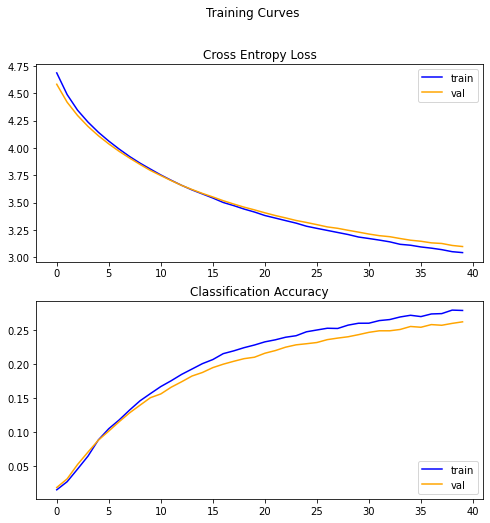

In [36]:
model1.evaluate(test_32_b256, verbose=1,steps=32)
summarize_diagnostics(history1)

##### 2o Πείραμα - Unfreeze Layzers

In [37]:
x=[13,1,0,0.4,0.4,0.07,1]
model2=create_model_vgg16(x)

13 1 0 0.4 0.4 0.07 1
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6ae0093f50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae007f7d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b500c0610> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ae0093250> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b4029c050> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae01c1650> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6b5267b990> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae007f290> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae0110750> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ba38dc050> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ae1daba10> True
<tensorflow.python.keras.layers.convolutional.

In [38]:
start = time.time()
history2=model2.fit(train_32_b256, epochs=40, batch_size=256,steps_per_epoch=132 ,verbose=1,validation_data=validation_32_b256,validation_steps=24,callbacks=[EarlyStopper])
print("Χρόνος fit:",time.time()-start)

Epoch 1/40
132/132 [==============================] - 10s 42ms/step - loss: 3.8187 - accuracy: 0.1386 - val_loss: 2.3080 - val_accuracy: 0.4004
Epoch 2/40
132/132 [==============================] - 5s 41ms/step - loss: 2.0444 - accuracy: 0.4472 - val_loss: 1.9112 - val_accuracy: 0.4855
Epoch 3/40
132/132 [==============================] - 5s 41ms/step - loss: 1.6194 - accuracy: 0.5445 - val_loss: 1.7833 - val_accuracy: 0.5145
Epoch 4/40
132/132 [==============================] - 5s 40ms/step - loss: 1.3612 - accuracy: 0.6055 - val_loss: 1.6604 - val_accuracy: 0.5389
Epoch 5/40
132/132 [==============================] - 5s 38ms/step - loss: 1.1629 - accuracy: 0.6622 - val_loss: 1.6480 - val_accuracy: 0.5584
Epoch 6/40
132/132 [==============================] - 5s 38ms/step - loss: 0.9686 - accuracy: 0.7119 - val_loss: 1.5978 - val_accuracy: 0.5672
Epoch 7/40
132/132 [==============================] - 5s 38ms/step - loss: 0.8140 - accuracy: 0.7582 - val_loss: 1.6712 - val_accuracy: 0.569

32/32 [==============================] - 3s 24ms/step - loss: 2.6391 - accuracy: 0.5756


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

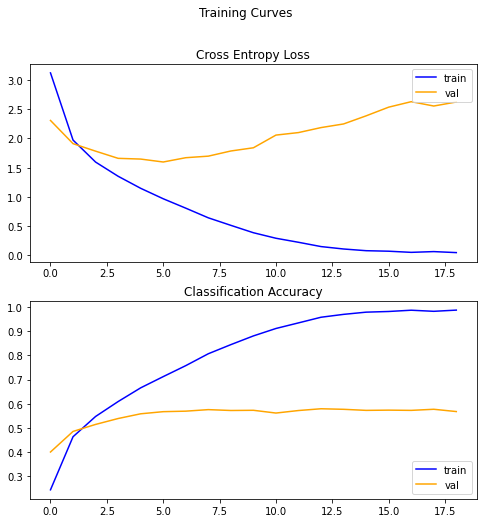

In [39]:
model2.evaluate(test_32_b256, verbose=1,steps=32)
summarize_diagnostics(history2)

##### 3o Πείραμα - Learning Rate Decay

In [40]:
x=[19,1,0,0.4,0.4,0.07,1]
model3=create_model_vgg16(x)

19 1 0 0.4 0.4 0.07 1
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6ad6536290> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad6516b50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad651ec90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ad6646e90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad67f4d50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad64d2450> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ad652d6d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad64cbf90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad64db0d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad64e8590> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ad64e8d50> True
<tensorflow.python.keras.layers.convolutional.Conv2D

In [41]:
start = time.time()
history3=model3.fit(train_32_b256, epochs=40, batch_size=256,steps_per_epoch=132 ,verbose=1,validation_data=validation_32_b256,validation_steps=24,callbacks=[EarlyStopper,reduce_lr])
print("Χρόνος fit:",time.time()-start)

Epoch 1/40
132/132 [==============================] - 10s 45ms/step - loss: 3.7472 - accuracy: 0.1392 - val_loss: 2.2832 - val_accuracy: 0.3973
Epoch 2/40
132/132 [==============================] - 6s 44ms/step - loss: 2.0149 - accuracy: 0.4511 - val_loss: 1.8842 - val_accuracy: 0.4867
Epoch 3/40
132/132 [==============================] - 6s 44ms/step - loss: 1.6188 - accuracy: 0.5431 - val_loss: 1.7309 - val_accuracy: 0.5182
Epoch 4/40
132/132 [==============================] - 6s 44ms/step - loss: 1.3724 - accuracy: 0.6062 - val_loss: 1.6471 - val_accuracy: 0.5425
Epoch 5/40
132/132 [==============================] - 6s 44ms/step - loss: 1.1516 - accuracy: 0.6645 - val_loss: 1.5976 - val_accuracy: 0.5539
Epoch 6/40
132/132 [==============================] - 6s 44ms/step - loss: 0.9680 - accuracy: 0.7136 - val_loss: 1.5681 - val_accuracy: 0.5758
Epoch 7/40
132/132 [==============================] - 6s 44ms/step - loss: 0.8333 - accuracy: 0.7522 - val_loss: 1.5840 - val_accuracy: 0.576

32/32 [==============================] - 2s 23ms/step - loss: 2.8522 - accuracy: 0.6069


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

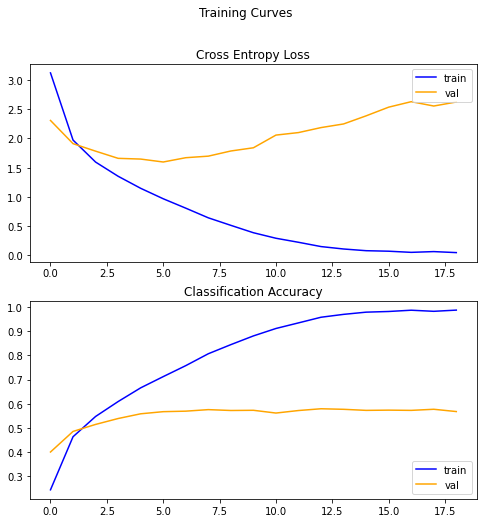

In [42]:
model3.evaluate(test_32_b256, verbose=1,steps=32)
summarize_diagnostics(history2)

##### 4ο Πείραμα - Add Extra Dense Layers

In [43]:
x=[19,1,3,0.4,0.3,0.07,1]
model4=create_model_vgg16(x)

19 1 3 0.4 0.3 0.07 1
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6ae1c748d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad6558c50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad6457d50> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ad65b1a90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad65b1c10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae021b050> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ad65cd910> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad65cd850> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae00d3e10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ad6566690> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ae00cb5d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D

In [45]:
start = time.time()
history4=model4.fit(train_32_b256, epochs=40, batch_size=256,steps_per_epoch=132 ,verbose=1,validation_data=validation_32_b256,validation_steps=24,callbacks=[EarlyStopper,reduce_lr])
print("Χρόνος fit:",time.time()-start)

Epoch 1/40
132/132 [==============================] - 10s 47ms/step - loss: 4.5411 - accuracy: 0.0186 - val_loss: 3.7666 - val_accuracy: 0.1019
Epoch 2/40
132/132 [==============================] - 6s 46ms/step - loss: 3.7843 - accuracy: 0.1003 - val_loss: 2.9807 - val_accuracy: 0.2394
Epoch 3/40
132/132 [==============================] - 6s 46ms/step - loss: 3.0867 - accuracy: 0.2110 - val_loss: 2.4002 - val_accuracy: 0.3704
Epoch 4/40
132/132 [==============================] - 6s 45ms/step - loss: 2.5759 - accuracy: 0.3133 - val_loss: 2.1795 - val_accuracy: 0.4165
Epoch 5/40
132/132 [==============================] - 6s 45ms/step - loss: 2.2695 - accuracy: 0.3895 - val_loss: 1.9787 - val_accuracy: 0.4621
Epoch 6/40
132/132 [==============================] - 6s 45ms/step - loss: 1.9990 - accuracy: 0.4518 - val_loss: 1.8528 - val_accuracy: 0.4974
Epoch 7/40
132/132 [==============================] - 6s 45ms/step - loss: 1.7678 - accuracy: 0.5066 - val_loss: 1.7771 - val_accuracy: 0.518

32/32 [==============================] - 2s 22ms/step - loss: 2.1347 - accuracy: 0.6024


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

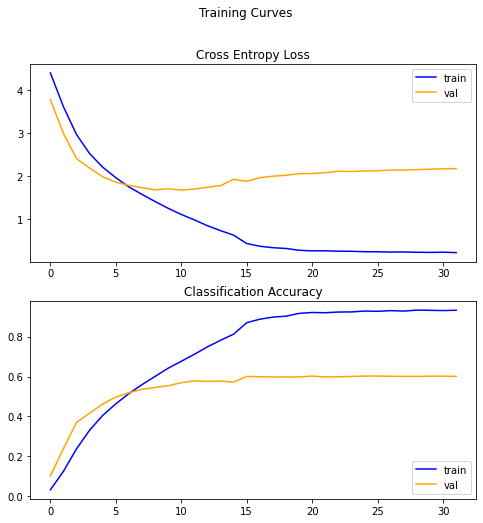

In [46]:
model4.evaluate(test_32_b256, verbose=1,steps=32)
summarize_diagnostics(history4)

##### 5o Πείραμα - Data Augmentation

In [50]:
x=[19,2,0,0.4,0.4,0.07,1]
model5=create_model_vgg16(x)

19 2 0 0.4 0.4 0.07 1
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6ae2763c10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae25cb910> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae270bd50> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ae2162c50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae25a7e90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae013da90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ae2761f90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae276c390> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae2076f50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b4ff86d90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ae2076950> True
<tensorflow.python.keras.layers.convolutional.Conv2D

In [51]:
start = time.time()
history5=model5.fit(train_32_b256, epochs=40, batch_size=256,steps_per_epoch=132 ,verbose=1,validation_data=validation_32_b256,validation_steps=24,callbacks=[EarlyStopper,reduce_lr])
print("Χρόνος fit:",time.time()-start)

Epoch 1/40
132/132 [==============================] - 10s 49ms/step - loss: 4.0217 - accuracy: 0.0896 - val_loss: 2.8089 - val_accuracy: 0.2739
Epoch 2/40
132/132 [==============================] - 6s 47ms/step - loss: 2.6613 - accuracy: 0.3041 - val_loss: 2.5038 - val_accuracy: 0.3371
Epoch 3/40
132/132 [==============================] - 6s 48ms/step - loss: 2.3479 - accuracy: 0.3719 - val_loss: 2.3166 - val_accuracy: 0.3742
Epoch 4/40
132/132 [==============================] - 6s 47ms/step - loss: 2.1376 - accuracy: 0.4192 - val_loss: 2.1948 - val_accuracy: 0.4106
Epoch 5/40
132/132 [==============================] - 6s 47ms/step - loss: 2.0351 - accuracy: 0.4365 - val_loss: 2.1226 - val_accuracy: 0.4214
Epoch 6/40
132/132 [==============================] - 6s 47ms/step - loss: 1.9391 - accuracy: 0.4643 - val_loss: 2.0150 - val_accuracy: 0.4455
Epoch 7/40
132/132 [==============================] - 6s 47ms/step - loss: 1.8479 - accuracy: 0.4846 - val_loss: 2.0206 - val_accuracy: 0.447

32/32 [==============================] - 3s 31ms/step - loss: 1.8679 - accuracy: 0.5348


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

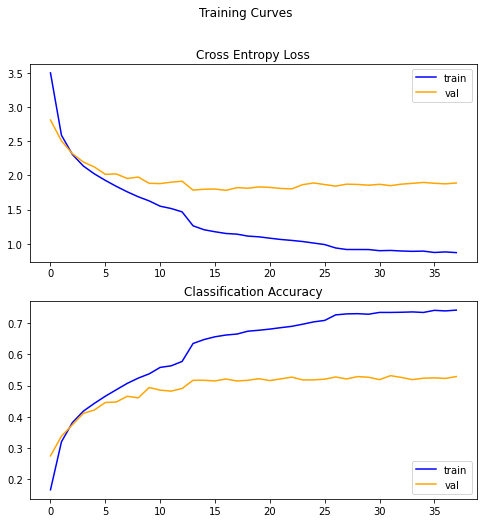

In [52]:
model5.evaluate(test_32_b256, verbose=1,steps=32)
summarize_diagnostics(history5)

##### 6o Πείραμα - Optimizer

In [56]:
x=[19,2,0,0.4,0.4,0.07,0]
model6=create_model_vgg16(x)

19 2 0 0.4 0.4 0.07 0
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6b020c67d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae278b610> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae25a7490> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ae203ca90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae219e7d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae25a7890> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6b020667d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b40247fd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b50197e10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ae25a7790> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ae2768090> True
<tensorflow.python.keras.layers.convolutional.Conv2D

In [57]:
start = time.time()
history6=model6.fit(train_32_b256, epochs=40, batch_size=256,steps_per_epoch=132 ,verbose=1,validation_data=validation_32_b256,validation_steps=24,callbacks=[EarlyStopper,reduce_lr])
print("Χρόνος fit:",time.time()-start)

Epoch 1/40
132/132 [==============================] - 10s 46ms/step - loss: 4.8609 - accuracy: 0.0049 - val_loss: 4.8128 - val_accuracy: 0.0055
Epoch 2/40
132/132 [==============================] - 6s 44ms/step - loss: 4.7989 - accuracy: 0.0062 - val_loss: 4.7687 - val_accuracy: 0.0076
Epoch 3/40
132/132 [==============================] - 6s 44ms/step - loss: 4.7593 - accuracy: 0.0070 - val_loss: 4.7342 - val_accuracy: 0.0101
Epoch 4/40
132/132 [==============================] - 6s 45ms/step - loss: 4.7203 - accuracy: 0.0092 - val_loss: 4.7010 - val_accuracy: 0.0098
Epoch 5/40
132/132 [==============================] - 6s 44ms/step - loss: 4.6988 - accuracy: 0.0100 - val_loss: 4.6707 - val_accuracy: 0.0119
Epoch 6/40
132/132 [==============================] - 6s 44ms/step - loss: 4.6662 - accuracy: 0.0103 - val_loss: 4.6378 - val_accuracy: 0.0117
Epoch 7/40
132/132 [==============================] - 6s 45ms/step - loss: 4.6301 - accuracy: 0.0136 - val_loss: 4.6069 - val_accuracy: 0.014

32/32 [==============================] - 3s 23ms/step - loss: 3.3888 - accuracy: 0.1774


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

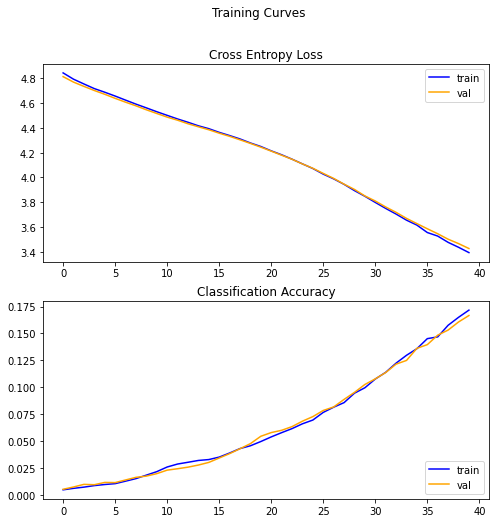

In [59]:
model6.evaluate(test_32_b256, verbose=1,steps=32)
summarize_diagnostics(history6)

##### 7o Πείραμα - Μέγεθος Εικόνας

In [63]:
x=[19,2,0,0.4,0.4,0.07,1]
model7=create_model_vgg16(x)

19 2 0 0.4 0.4 0.07 1
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6ab628fb90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ab628fe10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ab6287750> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ab629a5d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ab6288450> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ab642f550> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ab628fa10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ab657bdd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ab6287710> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ab6288290> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ab6285910> True
<tensorflow.python.keras.layers.convolutional.Conv2D

In [64]:
start = time.time()
history7=model7.fit(train_75_b256, epochs=40, batch_size=256,steps_per_epoch=132 ,verbose=1,validation_data=validation_75_b256,validation_steps=24,callbacks=[EarlyStopper,reduce_lr])
print("Χρόνος fit:",time.time()-start)

Epoch 1/40
132/132 [==============================] - 38s 188ms/step - loss: 3.4559 - accuracy: 0.1988 - val_loss: 1.6673 - val_accuracy: 0.5352
Epoch 2/40
132/132 [==============================] - 23s 173ms/step - loss: 1.3379 - accuracy: 0.6178 - val_loss: 1.3122 - val_accuracy: 0.6190
Epoch 3/40
132/132 [==============================] - 23s 174ms/step - loss: 0.9170 - accuracy: 0.7255 - val_loss: 1.2288 - val_accuracy: 0.6497
Epoch 4/40
132/132 [==============================] - 23s 173ms/step - loss: 0.6411 - accuracy: 0.8076 - val_loss: 1.2289 - val_accuracy: 0.6670
Epoch 5/40
132/132 [==============================] - 23s 174ms/step - loss: 0.4406 - accuracy: 0.8640 - val_loss: 1.2453 - val_accuracy: 0.6795
Epoch 6/40
132/132 [==============================] - 23s 174ms/step - loss: 0.2724 - accuracy: 0.9177 - val_loss: 1.2812 - val_accuracy: 0.6790
Epoch 7/40
132/132 [==============================] - 23s 174ms/step - loss: 0.1846 - accuracy: 0.9470 - val_loss: 1.4364 - val_ac

32/32 [==============================] - 8s 78ms/step - loss: 1.9704 - accuracy: 0.7146


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

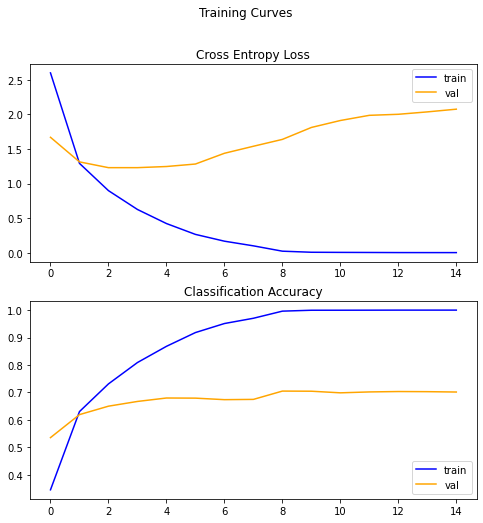

In [65]:
model7.evaluate(test_75_b256, verbose=1,steps=32)
summarize_diagnostics(history7)

##### 8o Πείραμα - Batch Size

In [74]:
x=[19,0,2,0.4,0.4,0.07,1]
model9=create_model_vgg16(x)
start = time.time()
history9=model9.fit(train_75_b64, epochs=40, batch_size=64,steps_per_epoch=532 ,verbose=1,validation_data=validation_75_b64,validation_steps=94,callbacks=[EarlyStopper,reduce_lr])
print("Χρόνος fit:",time.time()-start)

19 0 2 0.4 0.4 0.07 1
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6a5c4d9590> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a5c4d1990> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a5c5a0650> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6a5c519dd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a68617c90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a5c4f1a50> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6a5c500c90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a5c511650> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a5c58d2d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a5c4cc8d0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6a5c4a8750> True
<tensorflow.python.keras.layers.convolutional.Conv2D

128/128 [==============================] - 7s 17ms/step - loss: 2.1741 - accuracy: 0.7462


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

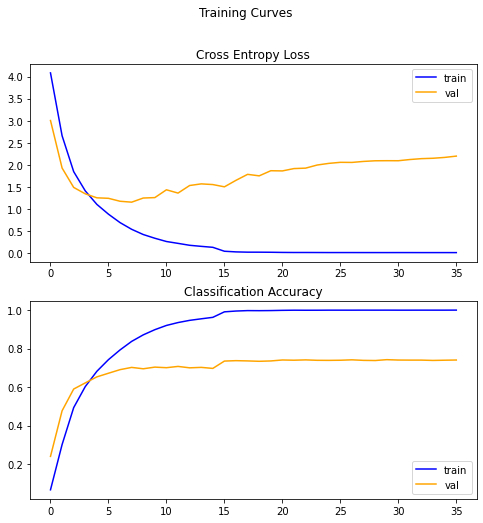

In [75]:
model9.evaluate(test_75_b64, verbose=1,steps=128)
summarize_diagnostics(history9)

##### Συμπεράσματα



Το τελικό μας πείραμα είναι και αυτό που πετυχαίνει τη βέλτιστη ακρίβεια στο Test set με 0.7462. Επίσης σημειώνεται ότι σημείωσε 951sec στην εκπαίδευση , χρόνος που αποτελεί τον τριπλάσιο τουλάχιστον από όλα τα υπόλοιπα πειράματα, όμως κατάφερε να φτάσει στην 36η εποχή , ενώ τα υπόλοιπα μοντέλα ολοκλήρωσαν λιγότερες εποχές λόγω του Early Stopping

Οι τελική αρχιτεκτονική, δηλαδή οι υπερπαράμετροι που αποφασίσαμε είναι :



*   Όλα τα στρώματα Trainable
*   Adam Optimizer
*   Όχι Data Augmentation
*   Ναι learning Decay
*   Mέγεθος εικόνας (75,75,3)
*   2 Extra Dense Layers
*   GlobalAvgPooling2D
*   Starting value for learning rate 0.00001
*   Batch Size = 64



Σύμφωνα με τα πειράματα οι πιο σημαντικές υπερπαράμετροι είναι οι εξής :



*   Αριθμός εκπαιδεύσιμων στρωμάτων
*   Optimizer 
*   Learining Rate


Παρατηρούμε σε όλα τα πειράματα οριακά να εμφανίζεται το φαινόμενο που γίνεται overfitting το μοντέλου στο train set. Αυτό φαίνεται από την καμπύλη του Validation Accuracy που αρχίζει και έχει διαφορά από το TrainSet Accuracy. Θα ήταν πιο ξεκάθαρο σημάδι αν η καμπύλη του Val Acc είχε πτωτική πορεία!

## Model from "scratch"

Aρχικά θα ξεκινήσουμε σαν βάση με το μοντέλο που προσφέρεται στο demo notebook και με διάφορα πειράματα θα βελτιώσουμε την απόδοση του.

### Base Model

In [76]:
def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [78]:
scratch=init_simple_model(True)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_10 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)              

In [79]:
start = time.time()
historys=scratch.fit(train_32_b256, epochs=40,batch_size=256,steps_per_epoch=132 ,verbose=1,validation_data=validation_32_b256,validation_steps=24,callbacks=[EarlyStopper])
print("Χρόνος fit:",time.time()-start)

Epoch 1/40
132/132 [==============================] - 9s 43ms/step - loss: 4.5713 - accuracy: 0.0146 - val_loss: 4.4139 - val_accuracy: 0.0291
Epoch 2/40
132/132 [==============================] - 5s 41ms/step - loss: 4.3283 - accuracy: 0.0332 - val_loss: 4.1194 - val_accuracy: 0.0498
Epoch 3/40
132/132 [==============================] - 5s 41ms/step - loss: 4.0476 - accuracy: 0.0640 - val_loss: 3.9585 - val_accuracy: 0.0923
Epoch 4/40
132/132 [==============================] - 5s 40ms/step - loss: 3.9118 - accuracy: 0.0940 - val_loss: 3.8652 - val_accuracy: 0.0975
Epoch 5/40
132/132 [==============================] - 5s 39ms/step - loss: 3.7909 - accuracy: 0.1142 - val_loss: 3.7760 - val_accuracy: 0.1120
Epoch 6/40
132/132 [==============================] - 5s 36ms/step - loss: 3.7214 - accuracy: 0.1233 - val_loss: 3.7271 - val_accuracy: 0.1224
Epoch 7/40
132/132 [==============================] - 4s 32ms/step - loss: 3.6497 - accuracy: 0.1366 - val_loss: 3.6500 - val_accuracy: 0.1362

32/32 [==============================] - 3s 23ms/step - loss: 2.9666 - accuracy: 0.2642


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

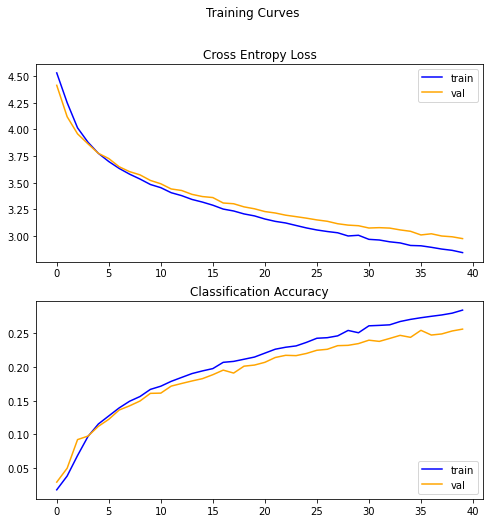

In [85]:
scratch.evaluate(test_32_b256, verbose=1,steps=32)
summarize_diagnostics(historys)

### Learning Rate Decay/Dropout/Larger Input shape

In [83]:
def simple_model_v1(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(75,75,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128,activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [84]:
scratch1=simple_model_v1(True)

start = time.time()
historys1=scratch1.fit(train_75_b64, epochs=40, batch_size=64,steps_per_epoch=532 ,verbose=1,validation_data=validation_75_b64,validation_steps=94,callbacks=[EarlyStopper,reduce_lr])
print("Χρόνος fit:",time.time()-start)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)     

128/128 [==============================] - 7s 16ms/step - loss: 3.0328 - accuracy: 0.3259


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

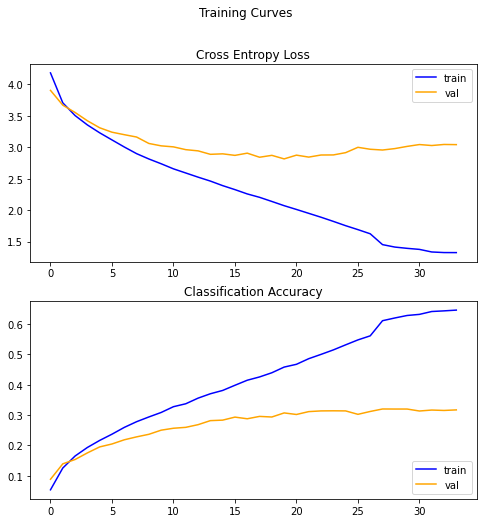

In [86]:
scratch1.evaluate(test_75_b64, verbose=1,steps=128)
summarize_diagnostics(historys1)

### Batch Normalization/Smaller input

In [102]:
def simple_model_v2(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(256,activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [103]:
scratch2=simple_model_v2(True)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 2, 2, 256)       

In [104]:
start = time.time()
historys2=scratch2.fit(train_32_b64, epochs=40, batch_size=64,steps_per_epoch=532 ,verbose=1,validation_data=validation_32_b64,validation_steps=94,callbacks=[EarlyStopper,reduce_lr])
print("Χρόνος fit:",time.time()-start)

Epoch 1/40
532/532 [==============================] - 10s 12ms/step - loss: 3.7819 - accuracy: 0.1109 - val_loss: 3.1583 - val_accuracy: 0.2475
Epoch 2/40
532/532 [==============================] - 7s 12ms/step - loss: 2.7267 - accuracy: 0.2980 - val_loss: 2.7054 - val_accuracy: 0.2990
Epoch 3/40
532/532 [==============================] - 6s 11ms/step - loss: 2.2352 - accuracy: 0.4024 - val_loss: 2.6119 - val_accuracy: 0.3348
Epoch 4/40
532/532 [==============================] - 6s 11ms/step - loss: 1.9607 - accuracy: 0.4604 - val_loss: 2.3795 - val_accuracy: 0.3802
Epoch 5/40
532/532 [==============================] - 6s 11ms/step - loss: 1.6805 - accuracy: 0.5323 - val_loss: 2.5761 - val_accuracy: 0.3635
Epoch 6/40
532/532 [==============================] - 6s 11ms/step - loss: 1.4575 - accuracy: 0.5842 - val_loss: 2.3894 - val_accuracy: 0.4044
Epoch 7/40
532/532 [==============================] - 5s 10ms/step - loss: 1.2327 - accuracy: 0.6403 - val_loss: 2.5505 - val_accuracy: 0.405

128/128 [==============================] - 3s 7ms/step - loss: 3.6429 - accuracy: 0.4546


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

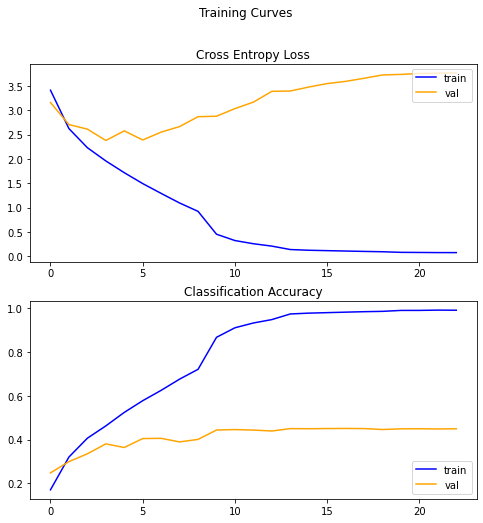

In [110]:
scratch2.evaluate(test_32_b64, verbose=1,steps=128)
summarize_diagnostics(historys2)

### Deeper Architecture

In [107]:
def simple_model_v3(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(2024,activation='relu'))
  model.add(layers.Dense(512,activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [108]:
scratch3=simple_model_v3(True)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 4, 4, 512)       

In [109]:
start = time.time()
historys3=scratch3.fit(train_32_b64, epochs=40, batch_size=64,steps_per_epoch=532 ,verbose=1,validation_data=validation_32_b64,validation_steps=94,callbacks=[EarlyStopper,reduce_lr])
print("Χρόνος fit:",time.time()-start)

Epoch 1/40
532/532 [==============================] - 10s 12ms/step - loss: 3.9573 - accuracy: 0.0780 - val_loss: 3.3119 - val_accuracy: 0.2121
Epoch 2/40
532/532 [==============================] - 6s 11ms/step - loss: 2.9695 - accuracy: 0.2476 - val_loss: 2.7020 - val_accuracy: 0.3082
Epoch 3/40
532/532 [==============================] - 6s 11ms/step - loss: 2.4206 - accuracy: 0.3612 - val_loss: 2.5150 - val_accuracy: 0.3514
Epoch 4/40
532/532 [==============================] - 6s 11ms/step - loss: 1.9923 - accuracy: 0.4553 - val_loss: 2.3702 - val_accuracy: 0.3836
Epoch 5/40
532/532 [==============================] - 6s 11ms/step - loss: 1.6438 - accuracy: 0.5342 - val_loss: 2.4224 - val_accuracy: 0.3961
Epoch 6/40
532/532 [==============================] - 6s 11ms/step - loss: 1.2757 - accuracy: 0.6286 - val_loss: 2.5243 - val_accuracy: 0.4056
Epoch 7/40
532/532 [==============================] - 6s 10ms/step - loss: 0.9646 - accuracy: 0.7136 - val_loss: 2.9194 - val_accuracy: 0.394

128/128 [==============================] - 3s 7ms/step - loss: 5.4728 - accuracy: 0.4596


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

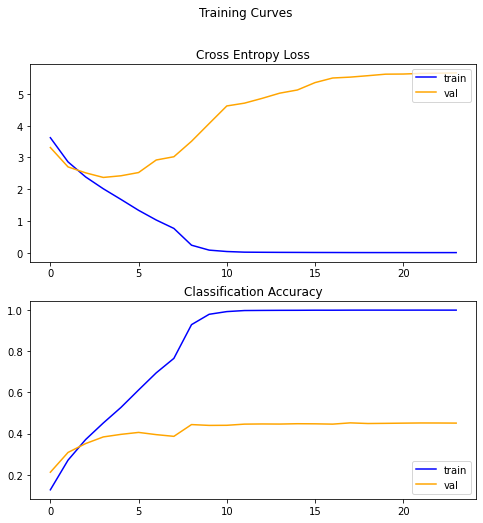

In [111]:
scratch3.evaluate(test_32_b64, verbose=1,steps=128)
summarize_diagnostics(historys3)

### Συμπεράσματα

Έπειτα από διάφορες δόκιμες η μέγιστη ακρίβεια που καταφέρνουμε είναι στο τελευταίο μοντέλο με TestSet Accuracy  = 0.4596 ενώ στο αρχικό μοντέλο επιτύχαμε TestSet Accuracy = 0.2642.

Οι βασικές αλλαγές φαίνονται και στη δομή του κώδικα αλλά αναφορικά να πούμε ότι είναι το λίγο μεγαλύτερο βάθος του μοντέλου, η εισαγωγή στρώματος Batch Normalization και η προσαρμογή του Learning Rate. Στο τελευταίο πείραμα αλλάξαμε το patience από 3 σε 2 και παρατηρήσαμε ελάχιστα καλύτερα αποτελέσματα. Κρίσιμη ήταν και η επιλογή του input_size καθώς τείνει να εκπαιδεύεται καλύτερα για μικρότερα μεγέθη.

Τέλος από τα διαγράμματα πάλι παρατηρούμε ότι το μοντέλο προσαρμόζεται αρκετά καλά στο train set, δίχως να έχει την ίδια επιτυχία στο validation set.